In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
from glob import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [7]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def gh_to_xarray(gh_dir, bbox, epsg=4326, interpolate_na=False):
    
    dirs = os.listdir(gh_dir)
    datasets = []
    acquisition_list = []
    
    for idir in dirs:
        tif_path = glob(f'{gh_dir}/{idir}/*.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        date = datetime.strptime(tif_fn[0:8], '%Y%m%d')
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"time": date})
        src = src.expand_dims("time")
        
        src = src.rename({'band1':'snow_depth'})
        src = src.rio.write_crs(epsg)
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)

        src = src.rio.clip_box(bbox[0], bbox[1], bbox[2], bbox[3])
        
        datasets.append(src)
        #print(src[file_type].shape, src.dates.item())
       
    ds = xr.concat(datasets, dim="time", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('time')

    return ds 

In [3]:
data_path = '../../data/merced_application'

In [8]:
sd_ds = gh_to_xarray(data_path, bbox=[-119.74, 37.55, -119.21, 37.94])

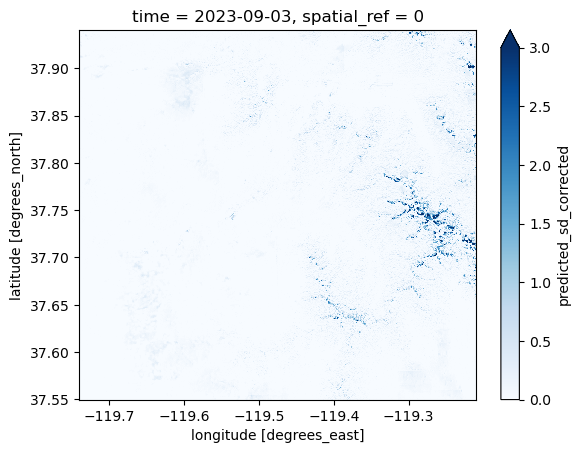

In [188]:
sd_ds.isel(time=180).snow_depth.plot.imshow(cmap='Blues', vmin=0, vmax=3)

In [189]:
sd_ds

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 228, y: 777, x: 1055)
Coordinates:
  * x            (x) float64 8kB -119.7 -119.7 -119.7 ... -119.2 -119.2 -119.2
  * y            (y) float64 6kB 37.94 37.94 37.94 37.94 ... 37.55 37.55 37.55
  * time         (time) datetime64[ns] 2kB 2017-10-04 2017-10-16 ... 2025-03-20
    spatial_ref  int64 8B 0
Data variables:
    snow_depth   (time, y, x) float64 1GB 0.0004215 0.0 ... 0.0894 0.01111
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      predicted_sd_corrected

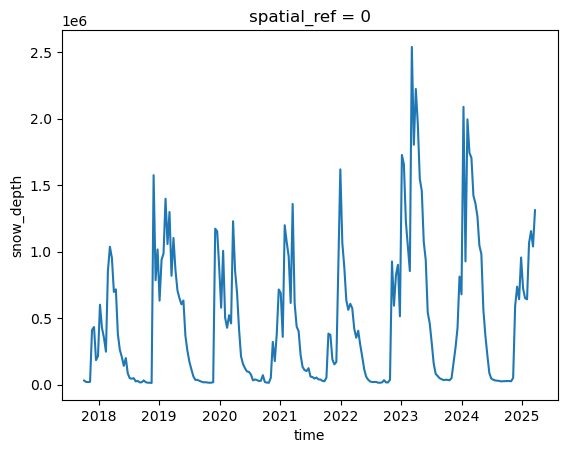

In [193]:
sd_ds.snow_depth.sum(dim=['x', 'y']).plot()